In [1]:
#@title install packages
#!pip install japanize-matplotlib==1.1.3
#!pip install arviz==0.11.4
#!pip install tensorflow_probability==0.14.1
#!pip install tensorflow==2.7.0
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00


In [3]:
#@title Import packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import japanize_matplotlib
import arviz as az

import tensorflow_probability as tfp
import tensorflow as tf
tfb = tfp.bijectors
tfd = tfp.distributions

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
colors = sns.color_palette('tab10')
#japanize_matplotlib.japanize()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
#@title Utility functions
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)

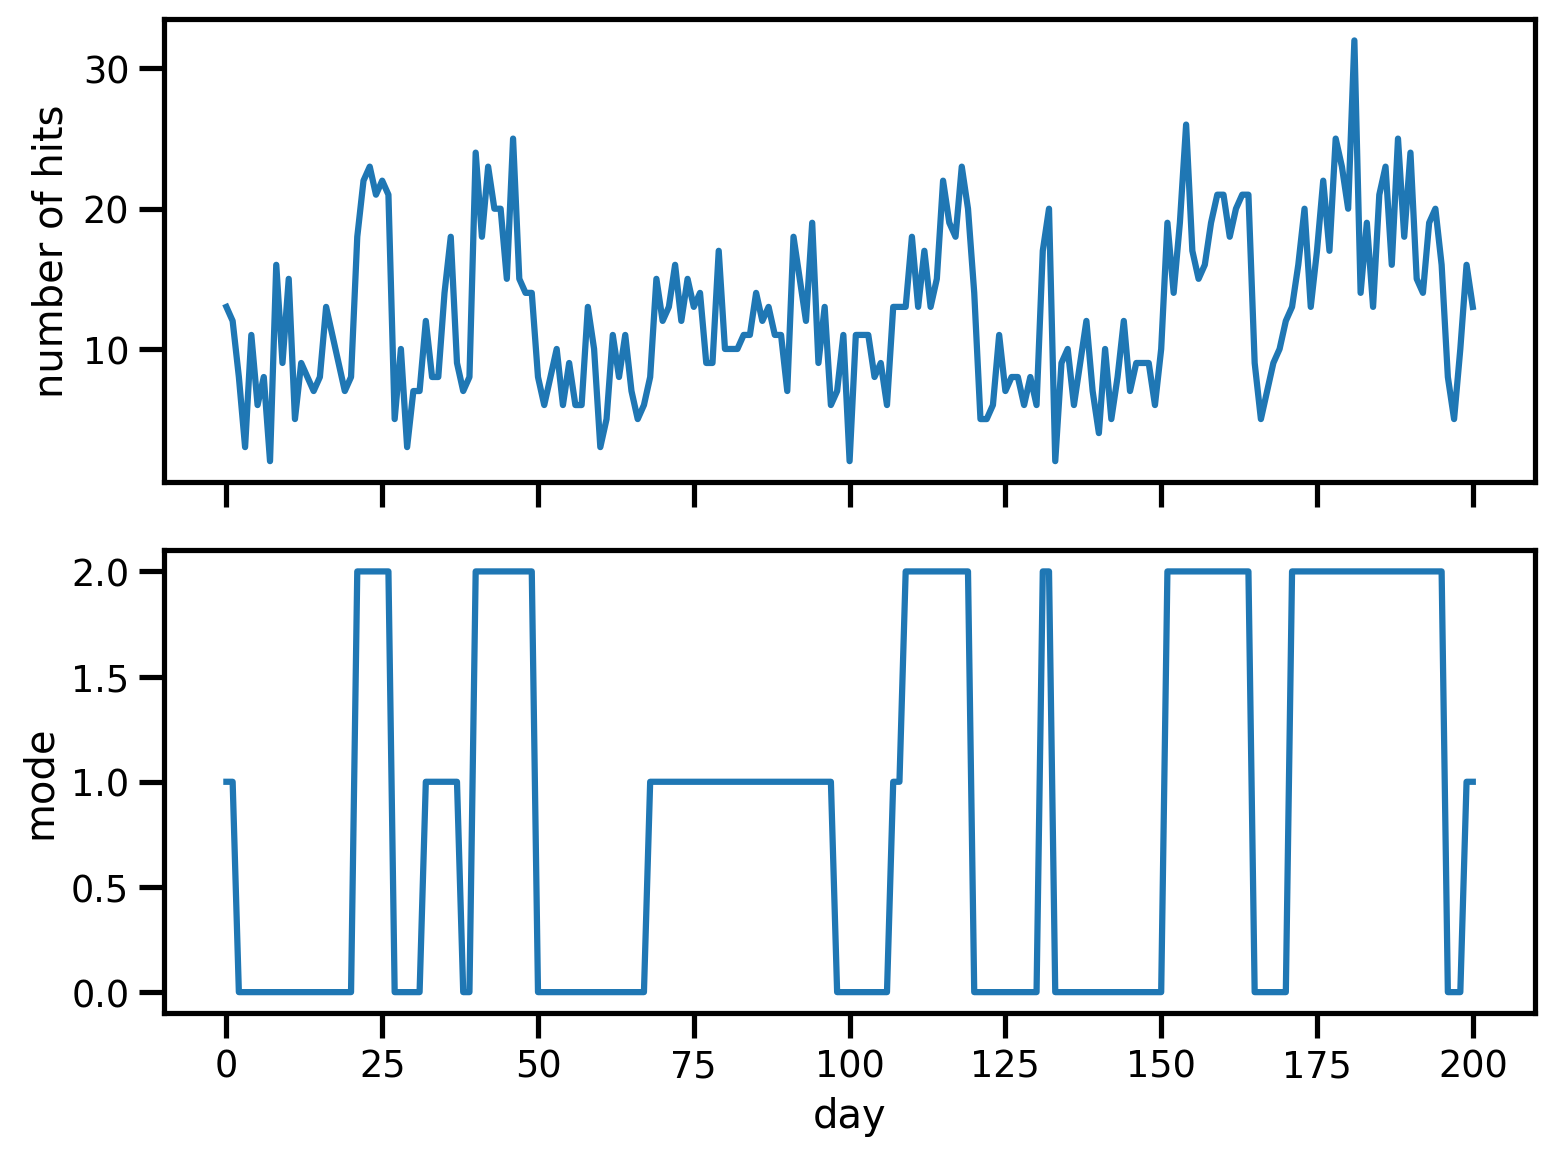

In [6]:
#@title generate simulation data
T = 200
n_state = 3
true_pi = [0.3, 0.6, 0.1]
true_A = [[0.91, 0.05, 0.04], [0.07, 0.90, 0.03], [0.04, 0.02, 0.94]]
true_lam = [8, 12, 18]

np.random.seed(1)
z_s = np.random.choice(n_state, p=true_pi)
z = [z_s]
for _ in range(T):
    z_s = np.random.choice(n_state, p=true_A[z_s])
    z.append(z_s)

x = np.random.poisson(np.array(true_lam)[z])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax = axes[0]
ax.plot(x)
ax.set_ylabel('number of hits')
ax = axes[1]
ax.plot(z)
ax.set_ylabel('mode')
ax.set_xlabel("day")
plt.tight_layout()

## Model definition
- $z_t|z_{t-1}$ ~ $Cat(A_{z_{t-1,:}})$
-  $x_t|z_t$ ~ $Poi(\lambda_{z_t})$

In [7]:
num_states = 3
Root = tfd.JointDistributionCoroutine.Root

#model definition
def model():
  #prior distribution
  #pi
  initial_probs = yield Root(
      tfd.Dirichlet(concentration=tf.ones(num_states))
  )#event shape : [3]
  #A
  transition_probs = yield Root(
      tfd.Independent(
          tfd.Dirichlet(
              concentration=tf.ones((num_states,num_states))
          ),
          reinterpreted_batch_ndims = 1
      )
  )#event shape: [3,3]
  #lambda
  rates = yield Root(
      tfd.Sample(
          tfd.Gamma(concentration=2,rate=0.1),
          sample_shape=num_states
      )
  )#event_shape:[3]

  #Hidden Markov Model
  hmm = yield tfd.HiddenMarkovModel(
      #initial probability
      initial_distribution = tfd.Categorical(probs=initial_probs),
      #transition matrix
      transition_distribution = tfd.Categorical(probs=transition_probs),
      #observation
      observation_distribution = tfd.Poisson(rate=rates),
      #num of data
      num_steps = len(x)
  )

joint = tfd.JointDistributionCoroutine(model)

def target_log_prob_fn(initial_probs,transition_probs,rates):
  return joint.log_prob(initial_probs,transition_probs,rates,x)


## Inference

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorat

initial_probs
[1.003 1.    1.007]

transition_probs
[[1.013 1.007 1.012]
 [1.    1.001 1.002]
 [1.005 1.008 1.008]]

rates
[1.02  1.014 1.004]



array([<Axes: title={'center': 'rates\n0'}>,
       <Axes: title={'center': 'rates\n1'}>,
       <Axes: title={'center': 'rates\n2'}>], dtype=object)

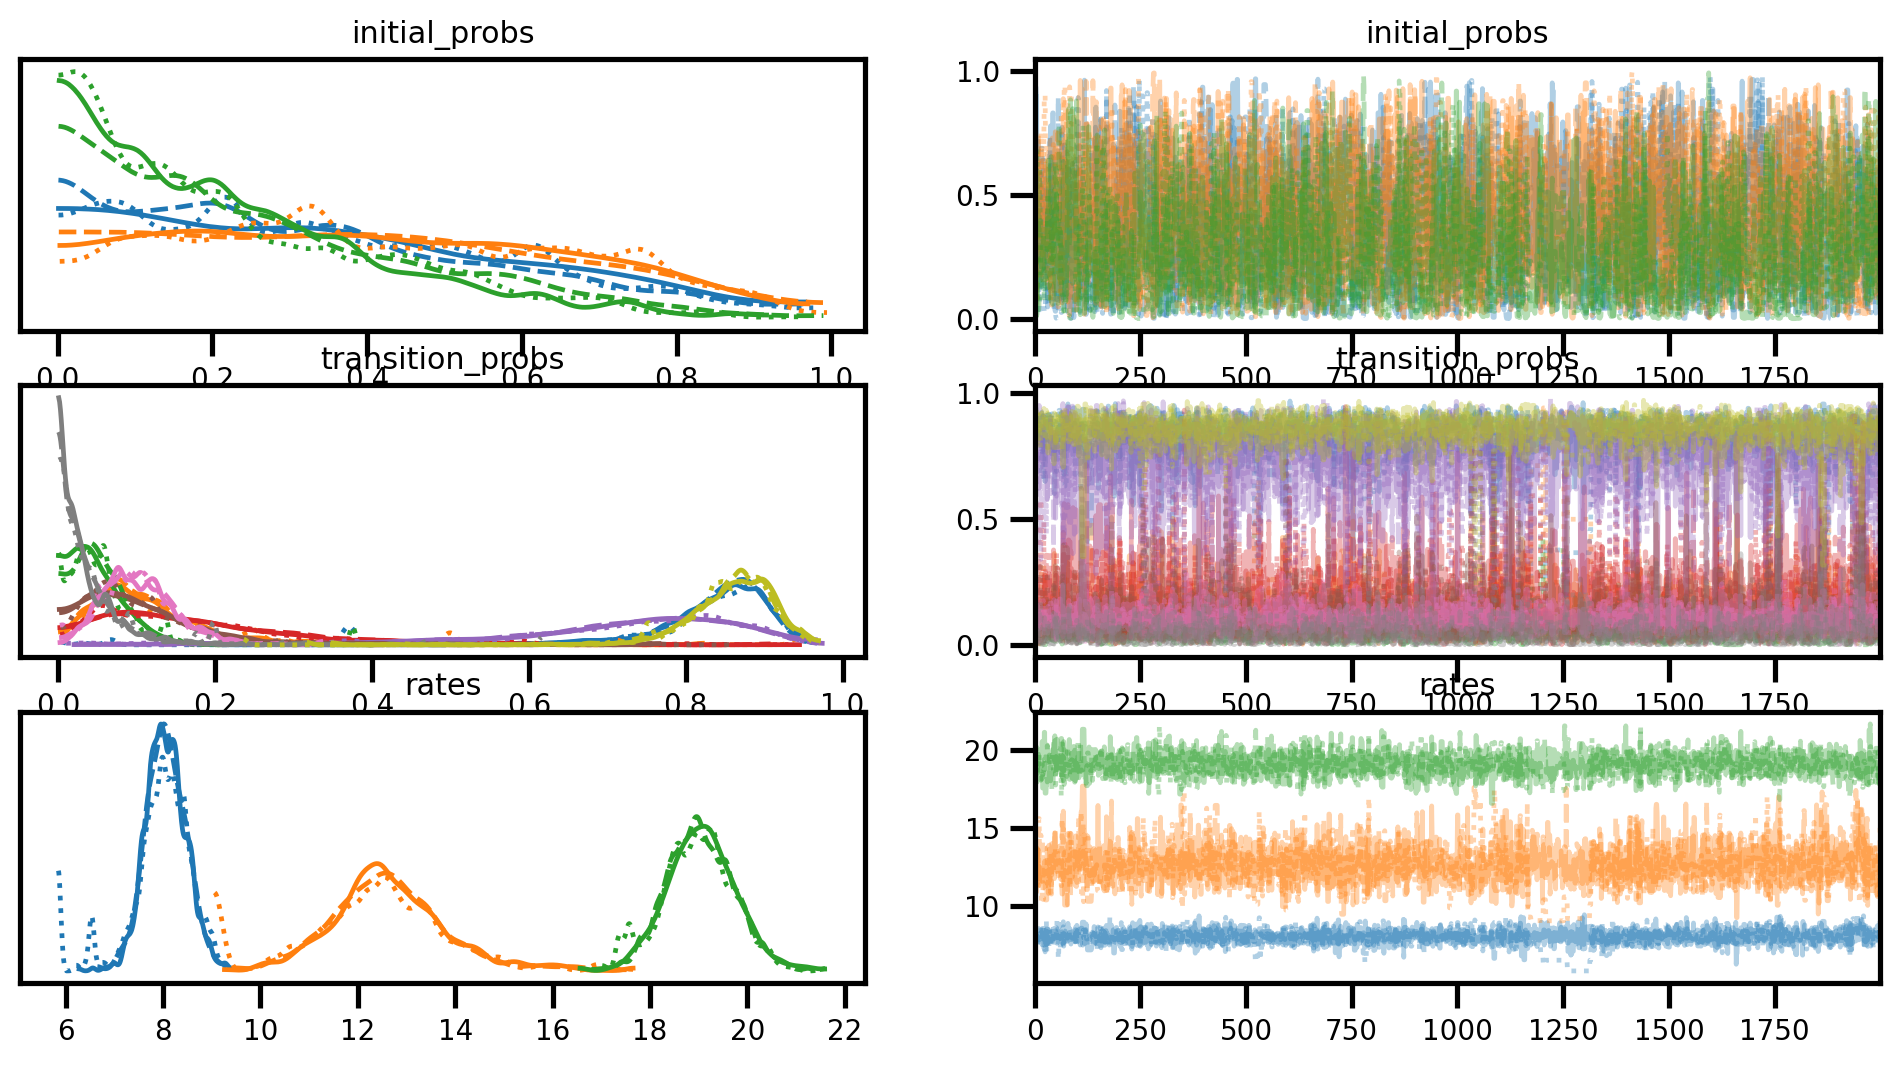

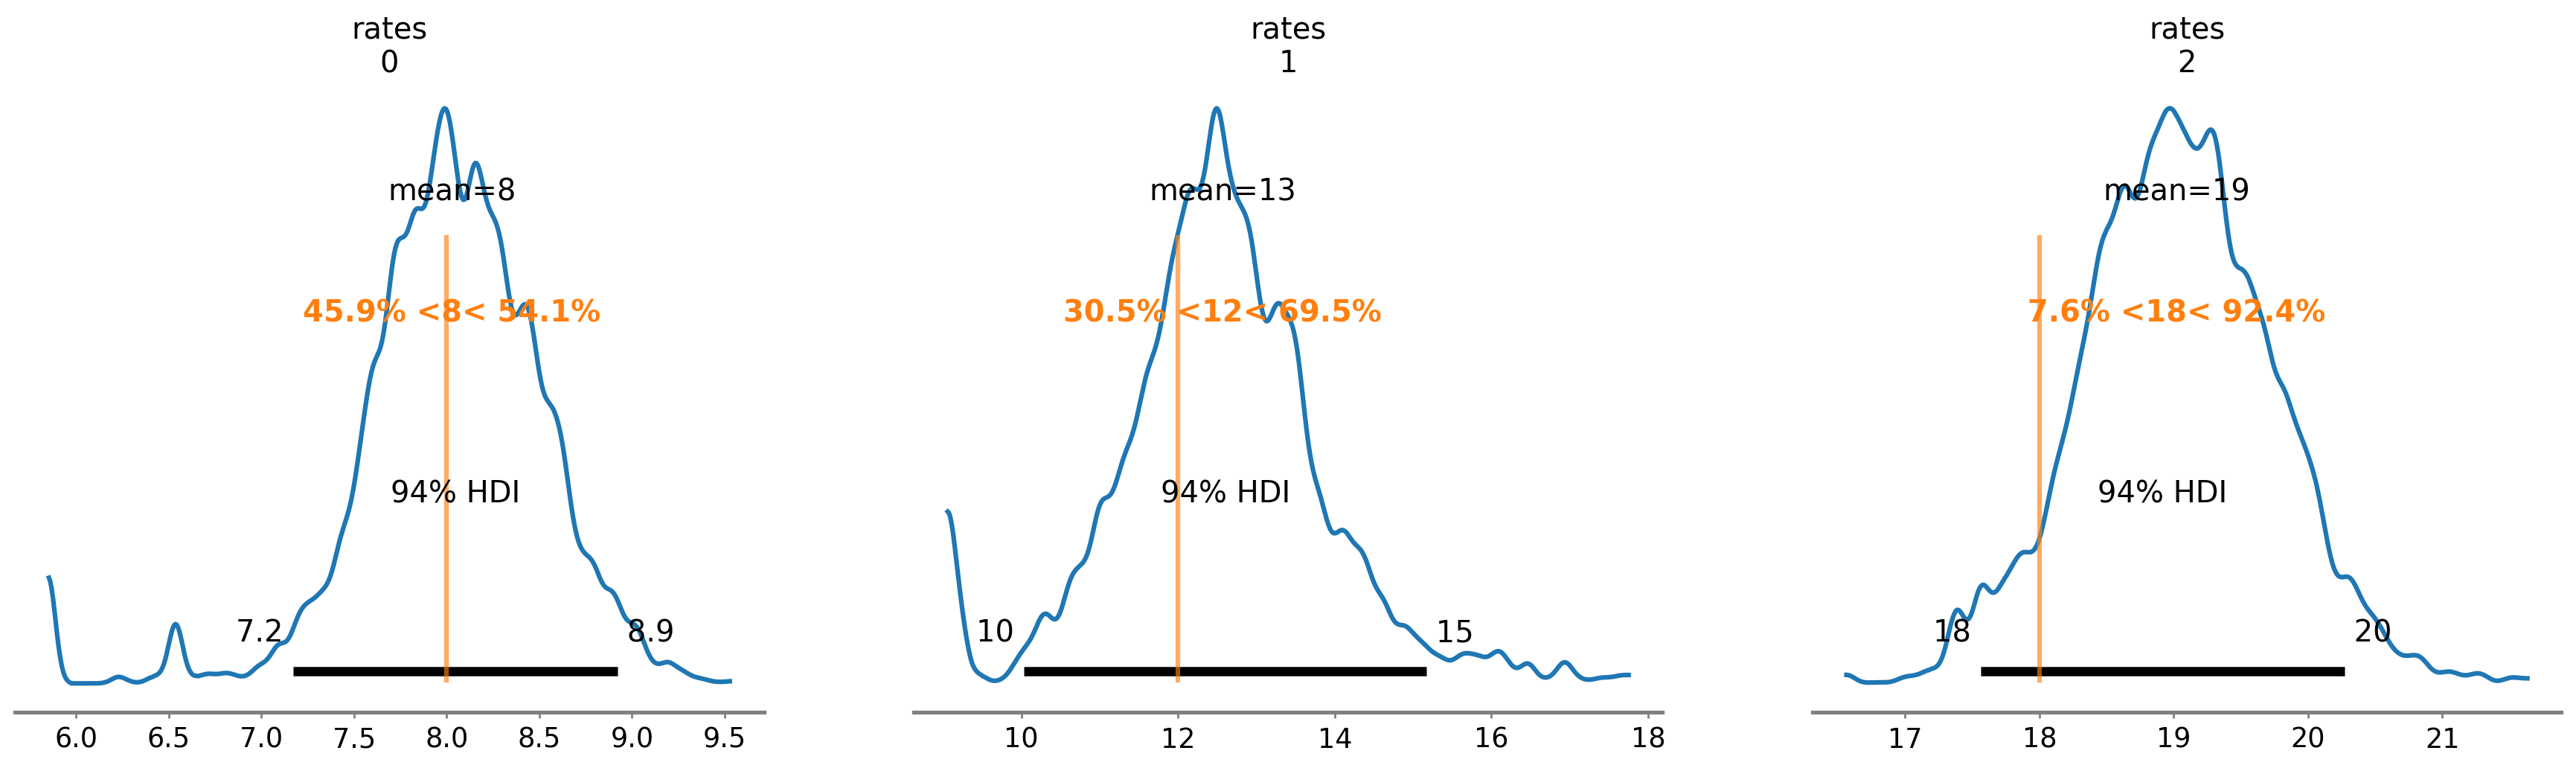

In [14]:
num_results = 2000
num_burnin_steps = 1000
n_chains = 3

tf.random.set_seed(42)

#transformation of variables
unconstraining_bijectors = [tfb.SoftmaxCentered(), #pi
                            tfb.SoftmaxCentered(), #transition : A
                            tfb.Chain([
                                tfb.Ascending(), #lambda : prevent label switching -> tfb.Ascending()
                                tfb.Softplus()
                            ])
                            ]
#initial parameters
current_state = [
    tf.ones([n_chains,num_states])/num_states, #pi
    tf.ones([n_chains,num_states,num_states])/num_states, #transition
    tf.stack([
        tf.random.uniform([n_chains],4,9),
        tf.random.uniform([n_chains],10,15),
        tf.random.uniform([n_chains],16,21)
    ],axis=1)#lambda
]

#Inference by Hamiltonian MonteCarlo
#step size <- SimpleStepSizeAdaptation
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.1,
            num_leapfrog_steps=10
        ),
        bijector=unconstraining_bijectors
    ),
    num_adaptation_steps=int(num_burnin_steps*0.8)
)

#sampling
@tf.function(autograph=False,experimental_compile=True)
def do_sampling(num_results,num_burnin_steps,current_state,kernel):
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=current_state,
      kernel=kernel
  )

#Execution :: inference
states, kernel_results = do_sampling(num_results,num_burnin_steps,current_state,kernel)

#check inference state
varnames = ["initial_probs","transition_probs","rates"]
trace = format_trace(states,varnames,chain_dim=1)
az.plot_trace(trace,var_names=["initial_probs","transition_probs","rates"])

for var_info in az.rhat(trace).values():
  print(var_info.name)
  print(var_info.values.round(3),sep=" ")
  print()

az.plot_posterior(trace,var_names=["rates"],ref_val=true_lam)

## Infer Latent variables

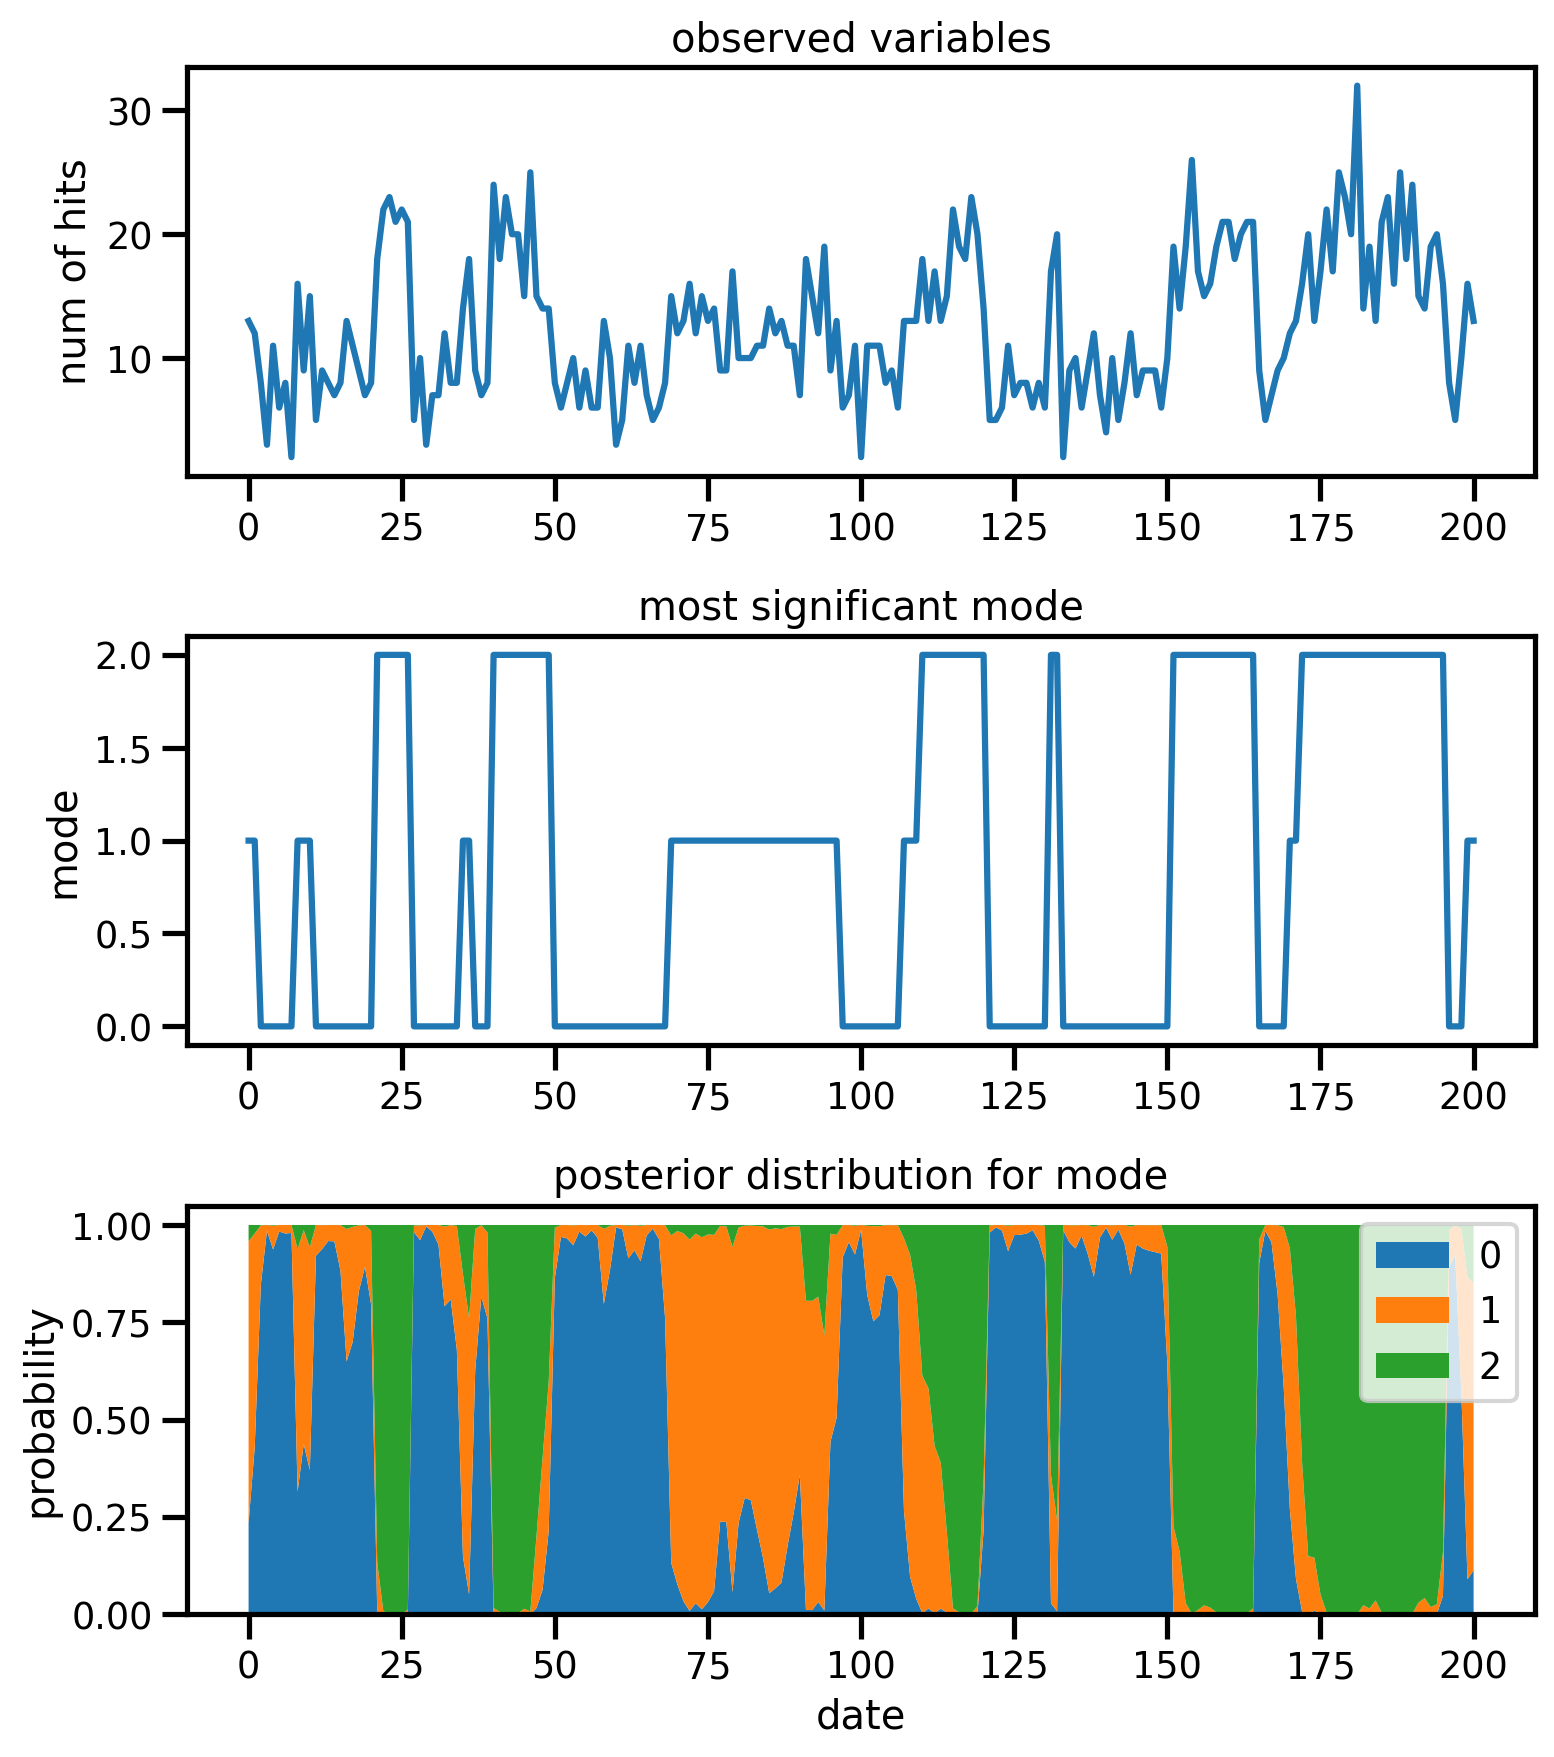

In [15]:
#using posterior distribution
hmm_post = tfd.HiddenMarkovModel(
    #init
    initial_distribution=tfd.Categorical(
        probs=trace.posterior["initial_probs"].mean(axis=(0,1))
    ),
    #transition
    transition_distribution = tfd.Categorical(
        probs = trace.posterior["transition_probs"].mean(axis=(0,1))
    ),
    #observation
    observation_distribution=tfd.Poisson(
        rate=trace.posterior["rates"].mean(axis=(0,1))
    ),
    #num data
    num_steps = len(x)
)

fig, axes = plt.subplots(3, 1, figsize=(8, 9))
ax=axes[0]
ax.plot(x)
ax.set_ylabel('num of hits')
ax.set_title('observed variables')

ax=axes[1]
ax.plot(hmm_post.posterior_mode(x.astype(np.float32)))
ax.set_ylabel('mode')
ax.set_title('most significant mode')

posterior_probs = hmm_post.posterior_marginals(
    x.astype(np.float32)).probs_parameter()
ax = axes[2]
ax.stackplot(np.arange(len(x)), posterior_probs.numpy().T, labels=[0,1,2])
ax.set_ylabel('probability')
ax.set_xlabel('date')
ax.set_title('posterior distribution for mode')
ax.legend()
plt.tight_layout()
